In [1]:
import os
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

import itertools
from collections import Counter 
from nltk.corpus import stopwords
from pymystem3 import Mystem
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

C:\Users\Tuylenen\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Получение данных

In [2]:
def reading_group(html, label):
    
    with open(html) as f:
        page = f.read()
      
    author, date, text = [], [], []
    
    comments = re.findall(r'<div class="bp_post clear_fix "((.|\n)*?)Показать список оценивших', page)
    for comment in comments:
        comment = comment[0]
        author.append(re.search(r'<a class="bp_author"(.*)">(.*)</a>', comment)[2])
        date.append(re.search(r'<a class="bp_date"(.*)">(.*)</a>', comment)[2])
        try:
            text.append(re.search(r'<div class="bp_text">(.*)</div>', comment)[1])
        except:
            text.append('')

    t_c, h_c, p_c = [], [], []

    for comment in text:
        href = re.findall(r"^<a href(.*)mem_link(.*)(.*)</a>", comment)
        
        ret = 'return showPhoto' in comment
        p_c.append(ret)
        
        if href:        
            h_lst = []
            for n in href:
                href = re.findall(r'Board.mentionOver\(this\)">(.*)', n[1])
                h_lst.append(href)
            comment = "{}, {}".format(','.join(h_lst[0]), comment.split("</a>,")[1])
            h_c.append(h_lst[0])
        else:
            h_c.append("na")
        t_c.append(re.sub('<br><br>', '', re.sub('</?div(.*)>', '', comment)))

    comments = pd.DataFrame(list(zip(author, date, t_c, h_c, p_c)),
                            columns=['author', 'date', 'comment', 'mention', 'image'])
    
    
    if label:
        comments['is_fake'] = 0
    else:
        comments['is_fake'] = 1
    
    return comments

In [3]:
def create_df(directory, label):
    df = pd.DataFrame()
    path = './html/' + directory
    for filename in os.listdir(path):
        if filename.endswith(".html"):
            comments = reading_group(path + '/' + filename, label)
            df = pd.concat([df, comments], sort=True, ignore_index=True)
        else:
            continue 
    return df

**author** - the user that posted a comment<br>
**comment** - text of the review<br>
**date** - when a comment was created<br>
**image** - True (1) if photos are attached, false otherwise<br>
**mention** - True (1) if there is a mention at the start of the message of another user, false otherwise<br>
**is_fake** - target label, True (1) if a comment is fake, false otherwise

In [4]:
df_true = create_df('vk/true', True)
df_true.tail()

,author,comment,date,image,is_fake,mention
2067,Евгений Беляев,"Заказывал Yezzy bost v2, шли долго из за каран...",28 апр 2020 в 19:09,True,0,na
2068,Андрей Ярилов,Доброго времени суток!) Заказал Yeezy 350 v2 y...,28 апр 2020 в 20:55,False,0,na
2069,Андрей Белый,"Заказывал вчера, доставили сегодня. Спасибо бо...",29 апр 2020 в 22:35,True,0,na
2070,Екатерина Самылина,"Качественная сумка,обязательно буду заказывать...",вчера в 14:56,True,0,na
2071,Никита Добрынин,"Заказывал штаны Aape и лонгслив Heron Preston,...",вчера в 15:00,True,0,na


In [5]:
df_false = create_df('vk/false', False)
df_false.tail()

,author,comment,date,image,is_fake,mention
617,Вика Сергеева,"Получила свои вещи, бомбер и платье безумно ра...",30 апр 2018 в 18:34,False,1,na
618,Олександра Аравіцька,"Спасибо!!!!Очень быстро и никаких проблем, даж...",1 мая 2018 в 8:32,False,1,na
619,Олеся Фирсова,"Спасибо большое , получила платьице, цвет как ...",7 мая 2018 в 12:55,True,1,na
620,Анастасия Нестерова,Сегодня доставили мне мои шлёпки и джинсы. К к...,8 мая 2018 в 15:06,False,1,na
621,Наталья Белоусова,"Такой шикарный магазин и так мало отзывов ,это...",сегодня в 14:37,False,1,na


In [6]:
df = pd.concat([df_false, df_true], sort=True, ignore_index=True)
df

,author,comment,date,image,is_fake,mention
0,Магазин кроссовок / Sniiiky,Тема только для отзывов! За отзыв с фото вы по...,21 сен 2017 в 2:16,False,1,na
1,Анна Токарева,"Сегодня забрала на почте! Качество отличное, у...",25 ноя 2017 в 6:46,True,1,na
2,Магазин кроссовок / Sniiiky,"Анна, спасибо! <img class=""emoji_css"" alt=""&#...",25 ноя 2017 в 9:04,False,1,[Анна]
3,Анна Николаева,"Вчера получила, до сих пор не нарадуюсь и про ...",27 ноя 2017 в 16:20,True,1,na
4,Магазин кроссовок / Sniiiky,"Анна, спасибо! <img class=""emoji_css"" alt=""&#...",27 ноя 2017 в 19:22,False,1,[Анна]
...,...,...,...,...,...,...
2689,Евгений Беляев,"Заказывал Yezzy bost v2, шли долго из за каран...",28 апр 2020 в 19:09,True,0,na
2690,Андрей Ярилов,Доброго времени суток!) Заказал Yeezy 350 v2 y...,28 апр 2020 в 20:55,False,0,na
2691,Андрей Белый,"Заказывал вчера, доставили сегодня. Спасибо бо...",29 апр 2020 в 22:35,True,0,na
2692,Екатерина Самылина,"Качественная сумка,обязательно буду заказывать...",вчера в 14:56,True,0,na


## Предобработка данных

In [7]:
owners = ['BERISHMOT Store', 'Андрей Северец', 'Магазин кроссовок / Sniiiky',
          'Настя Осипова', '|Мобильные телефоны|', 'RUDI ROYALE', 'NICE DEVISE | Москва',
          'Lovely Shop - магазин женской одежды', 'Non S7op Shop (Nike~Reebok~Adidas~Asics)',
          'Модная женская одежда "Valum"', "Lady's Shop - магазин шикарной одежды"]

for i in owners:
    df = df[df.author != i]

In [8]:
def clean_str(string):
    """
    String cleaning: return only words
    """
    string = re.sub('<.*?>', '', string)
    string = re.sub(r"\s{2,}", " ", string)
    return string

df['comment'] = df['comment'].apply(clean_str)

In [9]:
df = df[df.comment.notna()]
df = df.drop(df.columns[[0]], axis=1)
df.to_csv('out.csv', encoding='utf-8-sig')

In [10]:
df = pd.read_csv('out.csv')
df = df.drop(df.columns[[0]], axis=1)
df

,comment,date,image,is_fake,mention
0,"Сегодня забрала на почте! Качество отличное, у...",25 ноя 2017 в 6:46,True,1,na
1,"Вчера получила, до сих пор не нарадуюсь и про ...",27 ноя 2017 в 16:20,True,1,na
2,Спасибо большое Всё отлично! Очень нравится,28 ноя 2017 в 14:07,True,1,na
3,Спасибо за офигенные кроссы &#129303;,1 дек 2017 в 20:55,True,1,na
4,"Всё получила, переживала за качество и что дру...",2 дек 2017 в 17:22,True,1,na
...,...,...,...,...,...
2146,"Заказывал Yezzy bost v2, шли долго из за каран...",28 апр 2020 в 19:09,True,0,na
2147,Доброго времени суток!) Заказал Yeezy 350 v2 y...,28 апр 2020 в 20:55,False,0,na
2148,"Заказывал вчера, доставили сегодня. Спасибо бо...",29 апр 2020 в 22:35,True,0,na
2149,"Качественная сумка,обязательно буду заказывать...",вчера в 14:56,True,0,na


In [11]:
df = df[df.mention == 'na']
df = df.reset_index().drop(['mention', 'index'], axis=1)

# Исследование данных

In [12]:
df['is_fake'].value_counts()

0    1324
1     452
Name: is_fake, dtype: int64

In [13]:
df['image'].value_counts()

True     1285
False     491
Name: image, dtype: int64

In [14]:
1285 / (1285 + 491)

0.723536036036036

In [15]:
len(df[(df.image==True) & (df.is_fake==1)]) / len(df[df.is_fake==1])

0.6946902654867256

In [16]:
len(df[(df.image==True) & (df.is_fake==0)]) / len(df[df.is_fake==0])

0.7333836858006042

In [17]:
df_add = df.copy()

df_add['count_words'] = df["comment"].apply(lambda x: len(str(x).split()))
df_add['count_unique_words'] = df["comment"].apply(lambda x: len(set(str(x).split())))
df_add['count_letters'] = df["comment"].apply(lambda x: len(str(x)))
df_add["count_punctuations"] = df["comment"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_add["count_words_upper"] = df["comment"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
df_add["count_words_title"] = df["comment"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

In [18]:
df_add.tail()

,comment,date,image,is_fake,count_words,count_unique_words,count_letters,count_punctuations,count_words_upper,count_words_title
1771,"Заказывал Yezzy bost v2, шли долго из за каран...",28 апр 2020 в 19:09,True,0,21,21,132,4,0,3
1772,Доброго времени суток!) Заказал Yeezy 350 v2 y...,28 апр 2020 в 20:55,False,0,36,36,230,11,0,6
1773,"Заказывал вчера, доставили сегодня. Спасибо бо...",29 апр 2020 в 22:35,True,0,18,17,125,4,0,3
1774,"Качественная сумка,обязательно буду заказывать...",вчера в 14:56,True,0,6,6,62,3,0,1
1775,"Заказывал штаны Aape и лонгслив Heron Preston,...",вчера в 15:00,True,0,15,15,111,7,0,4


In [19]:
df_add.columns

Index(['comment', 'date', 'image', 'is_fake', 'count_words',
       'count_unique_words', 'count_letters', 'count_punctuations',
       'count_words_upper', 'count_words_title'],
      dtype='object')

In [20]:
print(df_add[df_add.is_fake == True].count_words.mean())
print(df_add[df_add.is_fake == False].count_words.mean())

20.278761061946902
21.395770392749245


In [21]:
print(df_add[df_add.is_fake == True].count_unique_words.mean())
print(df_add[df_add.is_fake == False].count_unique_words.mean())

19.263274336283185
19.85347432024169


In [22]:
print(df_add[df_add.is_fake == True].count_letters.mean())
print(df_add[df_add.is_fake == False].count_letters.mean())

141.05752212389382
144.58383685800604


In [23]:
print(df_add[df_add.is_fake == True].count_punctuations.mean())
print(df_add[df_add.is_fake == False].count_punctuations.mean())

6.814159292035399
6.009818731117825


In [24]:
print(df_add[df_add.is_fake == True].count_words_upper.mean())
print(df_add[df_add.is_fake == False].count_words_upper.mean())

0.21238938053097345
0.36555891238670696


In [25]:
print(df_add[df_add.is_fake == True].count_words_title.mean())
print(df_add[df_add.is_fake == False].count_words_title.mean())

2.418141592920354
3.0589123867069485


## Tokenizing words

In [26]:
vocabulary = []
numWords = []
lemmatized_texts = []

def text_lemmatize(text):
    global vocabulary 
    global numWords
    try:
        text = re.sub(r"[^А-Яа-яё]", " ", text).strip()
        ps = Mystem()
        text = ps.lemmatize(text)
        lemmatized_texts.append(text)
        vocabulary.extend(text)
        numWords.append(len(text))
        return ' '.join(text)
    except:
        lemmatized_texts.append('')
        return ''

In [27]:
df_lem = df.copy()
df_lem['comment'] = df_lem['comment'].apply(text_lemmatize)

vocabulary = list(set(vocabulary))

print('Total reviews: ', len(numWords))
print('Total words: ', sum(numWords))
print('Vocabulary size: ', len(vocabulary))
print('Average number of words in a review: ', sum(numWords)/len(numWords))

Total reviews:  1750
Total words:  73588
Vocabulary size:  3011
Average number of words in a review:  42.050285714285714


In [28]:
df_lem['lemmas'] = lemmatized_texts
df_lem

,comment,date,image,is_fake,lemmas
0,сегодня забирать на почта качество ...,25 ноя 2017 в 6:46,True,1,"[сегодня, , забирать, , на, , почта, , ка..."
1,вчера получать до сей пора не нар...,27 ноя 2017 в 16:20,True,1,"[вчера, , получать, , до, , сей, , пора, ..."
2,спасибо большой все отличный очень ...,28 ноя 2017 в 14:07,True,1,"[спасибо, , большой, , все, , отличный, ,..."
3,спасибо за офигенный кросс \n,1 дек 2017 в 20:55,True,1,"[спасибо, , за, , офигенный, , кросс, \n]"
4,все получать переживать за качество ...,2 дек 2017 в 17:22,True,1,"[все, , получать, , переживать, , за, , к..."
...,...,...,...,...,...
1771,заказывать идти долго из ...,28 апр 2020 в 19:09,True,0,"[заказывать, , идти, , долго,..."
1772,добрый время сутки заказывать ...,28 апр 2020 в 20:55,False,0,"[добрый, , время, , сутки, , заказывать, ..."
1773,заказывать вчера доставлять сегодня ...,29 апр 2020 в 22:35,True,0,"[заказывать, , вчера, , доставлять, , сего..."
1774,качественный сумка обязательно быть за...,вчера в 14:56,True,0,"[качественный, , сумка, , обязательно, , бы..."


In [29]:
clean_lemmas = []
regex = re.compile(r'\s+')

for text in lemmatized_texts:
    clean_lemmas.append([i for i in text if not regex.search(i)])

df_lem['lemmas'] = clean_lemmas

In [30]:
stemmer = SnowballStemmer("russian", ignore_stopwords=True)
stems = []

for i in df_lem.lemmas:
    row = []
    for n in i:
        row.append(stemmer.stem(n))
    stems.append(row)    

In [31]:
df_lem['stem'] = stems
df_lem.head(3)

,comment,date,image,is_fake,lemmas,stem
0,сегодня забирать на почта качество ...,25 ноя 2017 в 6:46,True,1,"[сегодня, забирать, на, почта, качество, отлич...","[сегодн, забира, на, почт, качеств, отличн, уп..."
1,вчера получать до сей пора не нар...,27 ноя 2017 в 16:20,True,1,"[вчера, получать, до, сей, пора, не, нарадоват...","[вчер, получа, до, се, пор, не, нарадова, и, п..."
2,спасибо большой все отличный очень ...,28 ноя 2017 в 14:07,True,1,"[спасибо, большой, все, отличный, очень, нрави...","[спасиб, больш, все, отличн, очен, нрав]"


In [32]:
vocabulary_stem = list(itertools.chain.from_iterable([i for i in df_lem['stem']]))
len(set(vocabulary_stem))

2701

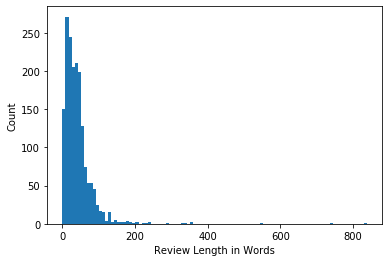

In [33]:
plt.hist(numWords, 100)
plt.xlabel('Review Length in Words')
plt.ylabel('Count')
plt.show()

In [35]:
df_lem.to_csv('out_bow.csv', encoding='utf-8-sig')

# Мешок слов

In [40]:
bagOfPositive = list(itertools.chain.from_iterable([i for i in df_lem.lemmas[df.is_fake == 1]])) 
bagOfNegative = list(itertools.chain.from_iterable([i for i in df_lem.lemmas[df.is_fake == 0]]))
bagOfAll = bagOfPositive+bagOfNegative

In [41]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words("russian"))

# Формируем для каждого документа словарь в котором ключ - это слово, а значение его частота в документе
mapOfWordsPositive = dict.fromkeys(vocabulary, 0)
mapOfWordsNegative = dict.fromkeys(vocabulary, 0)
mapOfAllWords = dict.fromkeys(vocabulary, 0)

for word in bagOfPositive:
    if word not in stop_words:
        mapOfWordsPositive[word] += 1
for word in bagOfNegative:
    if word not in stop_words:
        mapOfWordsNegative[word] += 1
for word in bagOfAll:
    if word not in stop_words:
        mapOfAllWords[word] += 1

In [42]:
from wordcloud import WordCloud

def word_cloud(list, file):
    cloud = WordCloud(background_color="white", max_words=100)
    cloud.generate(' '.join(list))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    cloud.to_file(file)

In [43]:
def maj_words(d):
    big_pos = []
    counter = 0
    for w in sorted(d, key=d.get, reverse=True)[:100]:
        big_pos.append(w)
        if counter < 20:
            print(w, d[w])
            counter +=  1
    return big_pos

In [44]:
mpn = maj_words(mapOfWordsNegative)

заказывать 930
качество 688
спасибо 615
приходить 530
виктор 416
очень 406
размер 349
весь 270
день 255
доставка 215
хороший 214
носок 214
магазин 211
подарок 200
кроссовок 195
отличный 185
это 184
довольный 183
идти 174
продавец 165


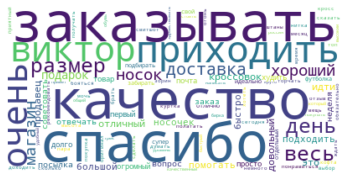

In [45]:
word_cloud(mpn, 'mpn.jpg')

In [46]:
mpp = maj_words(mapOfWordsPositive)

спасибо 279
очень 209
качество 162
заказывать 158
хороший 102
получать 98
довольный 95
большой 90
доставка 86
размер 86
платье 79
приходить 78
заказ 78
весь 68
магазин 61
подходить 55
отличный 53
свой 48
быстро 47
быстрый 47


In [47]:
common_items = list((Counter(mpp) & Counter(mpn)).elements())
len(common_items)

56

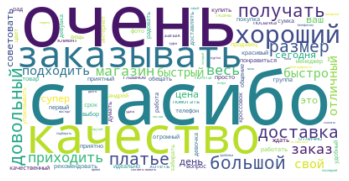

In [48]:
word_cloud(mpp, 'mpp.jpg')

In [49]:
mpa = maj_words(mapOfAllWords)

заказывать 1088
спасибо 894
качество 850
очень 615
приходить 608
размер 435
виктор 416
весь 338
хороший 316
доставка 301
день 299
довольный 278
магазин 272
отличный 238
большой 232
это 221
носок 216
кроссовок 213
подходить 212
подарок 209


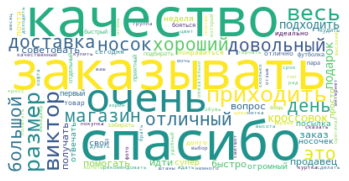

In [50]:
word_cloud(mpa, 'maj.jpg')

In [51]:
word_vectorizer = TfidfVectorizer(max_features=250000,  
                                  stop_words=stop_words,
                                  analyzer='word',
                                  ngram_range=(1,3))

In [52]:
TFIDF = word_vectorizer.fit_transform(bagOfPositive)
indices = np.argsort(word_vectorizer.idf_)[::-1]
features = word_vectorizer.get_feature_names()
top_n = 10
top_features = [features[i] for i in indices[:top_n]]
top_features

['игрушка',
 'премия',
 'забота',
 'принимать',
 'моментальный',
 'жилеточка',
 'прикреплять',
 'прикольно',
 'прийшов',
 'приемлемый']

In [53]:
TFIDF = word_vectorizer.fit_transform(bagOfNegative)
indices = np.argsort(word_vectorizer.idf_)[::-1]
features = word_vectorizer.get_feature_names()
top_n = 10
top_features = [features[i] for i in indices[:top_n]]
top_features

['ясно',
 'наугад',
 'налезать',
 'налички',
 'наполнитель',
 'напрасно',
 'напрасный',
 'нарадоваться',
 'наски',
 'наставать']

In [54]:
TFIDF = word_vectorizer.fit_transform(bagOfAll)
indices = np.argsort(word_vectorizer.idf_)[::-1]
features = word_vectorizer.get_feature_names()
top_n = 10
top_features = [features[i] for i in indices[:top_n]]
top_features

['ясно',
 'помешать',
 'помогална',
 'идиотский',
 'помогсделать',
 'помочь',
 'помощья',
 'идентичный',
 'идельный',
 'идеальнона']

In [66]:
df_end = df_lem.stem

stem_str = []

for i in df_end:
    stem_str.append(' '.join(i)  )

In [71]:
df_end =  df_lem.copy()
df_end['lem_str'] = stem_str

In [72]:
x = df_end['lem_str']
y = df_lem.is_fake

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=0)

In [73]:
train_words = word_vectorizer.transform(x_train)
test_words = word_vectorizer.transform(x_test)

# Logistic regression

In [135]:
from sklearn.metrics import roc_auc_score

Лучшие параметры найденные через ParameterGrid:

In [136]:
logreg = LogisticRegression(C=1, class_weight = {1: 0.7, 0: 0.3}, solver='liblinear', random_state=21)
logreg.fit(train_words, y_train)
pred = logreg.predict(test_words)

In [137]:
print(round(accuracy_score(y_test, pred), 3))
print(confusion_matrix(y_test, pred))
print(round(f1_score(y_test, pred), 3))
print(round(roc_auc_score(y_test, pred), 3))

0.857
[[236  30]
 [ 21  69]]
0.73
0.827


# Gaussian Naive Bayes

In [138]:
clf = GaussianNB()
clf.fit(train_words.toarray(), y_train)
pred = clf.predict(test_words.toarray())

In [139]:
print(round(accuracy_score(y_test, pred), 3))
print(confusion_matrix(y_test, pred))
print(round(f1_score(y_test, pred), 3))
print(round(roc_auc_score(y_test, pred), 3))

0.579
[[118 148]
 [  2  88]]
0.54
0.711


# Multinomial Naive Bayes

In [154]:
from sklearn.naive_bayes import MultinomialNB

In [155]:
mnb = MultinomialNB()
mnb .fit(train_words.toarray(), y_train)
pred = mnb .predict(test_words.toarray())

In [156]:
print(round(accuracy_score(y_test, pred), 3))
print(confusion_matrix(y_test, pred))
print(round(f1_score(y_test, pred), 3))
print(round(roc_auc_score(y_test, pred), 3))

0.792
[[266   0]
 [ 74  16]]
0.302
0.589


# k-nearest neighbors

Лучшие параметры найденные через ParameterGrid:

In [140]:
knn = KNeighborsClassifier(weights='distance')
knn.fit(train_words.toarray(),y_train)
pred = knn.predict(test_words.toarray())

In [141]:
import sklearn
from sklearn.metrics import log_loss

print(round(accuracy_score(y_test, pred), 3))
print(confusion_matrix(y_test, pred))
print(round(f1_score(y_test, pred), 3))
print(round(roc_auc_score(y_test, pred), 3))

0.82
[[253  13]
 [ 51  39]]
0.549
0.692


# Random Forest

In [142]:
rfclf = RandomForestClassifier(criterion='entropy', max_depth = 100)
rfclf.fit(train_words,y_train)
pred = rfclf.predict(test_words)

C:\Users\Tuylenen\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [143]:
print(round(accuracy_score(y_test, pred), 3))
print(confusion_matrix(y_test, pred))
print(round(f1_score(y_test, pred), 3))
print(round(roc_auc_score(y_test, pred), 3))

0.86
[[256  10]
 [ 40  50]]
0.667
0.759


# Gradient Boosting

In [144]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(train_words.toarray(), y_train)
pred = gb.predict(test_words.toarray())

In [145]:
print(round(accuracy_score(y_test, pred), 3))
print(confusion_matrix(y_test, pred))
print(round(f1_score(y_test, pred), 3))
print(round(roc_auc_score(y_test, pred), 3))

0.848
[[259   7]
 [ 47  43]]
0.614
0.726


# Метод опорных векторов

In [148]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [149]:
SVC = make_pipeline(StandardScaler(), SVC(gamma='auto'))
SVC.fit(train_words.toarray(), y_train)
pred = xgboost.predict(test_words.toarray())

In [150]:
print(round(accuracy_score(y_test, pred), 3))
print(confusion_matrix(y_test, pred))
print(round(f1_score(y_test, pred), 3))
print(round(roc_auc_score(y_test, pred), 3))

0.829
[[248  18]
 [ 43  47]]
0.606
0.727


<img src="./cm.jpeg" width="300">